In [24]:
import pandas as pd

# For GBD Regions
df = pd.read_csv("/Users/emilypalm/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/AquaLens/Machine_Learning/IHME-GBD_2021_DATA-d09f194b-1/GBD_regions.csv")

# For Super Regions 
df_super = pd.read_csv("/Users/emilypalm/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/AquaLens/Machine_Learning/IHME-GBD_2021_DATA-a6833097-1/GBD_super_regions.csv")

# Preview data
df.head(5)

,measure_id,measure_name,location_id,location_name,sex_id,sex_name,age_id,age_name,cause_id,cause_name,metric_id,metric_name,year,val,upper,lower
0,1,Deaths,44559,Africa,3,Both,27,Age-standardized,1029,Total cancers,3,Rate,1980,98.650337,109.522451,87.498318
1,1,Deaths,44560,America,3,Both,27,Age-standardized,294,All causes,3,Rate,1980,923.292919,933.168966,913.655034
2,1,Deaths,44560,America,3,Both,27,Age-standardized,302,Diarrheal diseases,3,Rate,1980,33.678220,36.850467,30.691216
3,1,Deaths,44560,America,3,Both,27,Age-standardized,322,Lower respiratory infections,3,Rate,1980,51.581241,54.076450,48.789575
4,1,Deaths,239,East Asia & Pacific - WB,3,Both,27,Age-standardized,294,All causes,3,Rate,1982,1239.772376,1326.270896,1156.830272


In [ ]:
#preview data for super regions
df_super.head(5)

,measure_id,measure_name,location_id,location_name,sex_id,sex_name,age_id,age_name,cause_id,cause_name,metric_id,metric_name,year,val,upper,lower
0,1,Deaths,4,"Southeast Asia, East Asia, and Oceania",3,Both,27,Age-standardized,302,Diarrheal diseases,3,Rate,1980,61.512074,90.695135,38.690806
1,1,Deaths,4,"Southeast Asia, East Asia, and Oceania",3,Both,27,Age-standardized,294,All causes,3,Rate,1980,1384.055535,1492.950519,1278.608669
2,1,Deaths,4,"Southeast Asia, East Asia, and Oceania",3,Both,27,Age-standardized,322,Lower respiratory infections,3,Rate,1980,74.308886,82.536399,66.633186
3,1,Deaths,4,"Southeast Asia, East Asia, and Oceania",3,Both,27,Age-standardized,491,Cardiovascular diseases,3,Rate,1980,437.538235,483.428459,392.574117
4,1,Deaths,166,Sub-Saharan Africa,3,Both,27,Age-standardized,1029,Total cancers,3,Rate,1980,106.716808,119.222024,93.123656


In [17]:
#check all available super regions
df_super['location_name'].unique()

array(['Southeast Asia, East Asia, and Oceania', 'Sub-Saharan Africa',
       'Latin America and Caribbean', 'North Africa and Middle East',
       'World Bank Regions', 'WHO region', 'High-income',
       'Central Europe, Eastern Europe, and Central Asia',
       'High-middle SDI', 'South Asia', 'European Union', 'African Union',
       'High SDI', 'Four World Regions', 'Health System Grouping Levels',
       'League of Arab States', 'Commonwealth',
       'Organization of Islamic Cooperation', 'Low-middle SDI',
       'OECD Countries', 'Low SDI', 'Middle SDI', 'Nordic Region', 'G20',
       'Association of Southeast Asian Nations',
       'Gulf Cooperation Council', 'Sahel Region'], dtype=object)

In [18]:
#number of rows per region
df_super['location_name'].value_counts()

location_name
Southeast Asia, East Asia, and Oceania              210
Health System Grouping Levels                       210
Gulf Cooperation Council                            210
Association of Southeast Asian Nations              210
G20                                                 210
Nordic Region                                       210
Middle SDI                                          210
Low SDI                                             210
OECD Countries                                      210
Low-middle SDI                                      210
Organization of Islamic Cooperation                 210
Commonwealth                                        210
League of Arab States                               210
Four World Regions                                  210
Sub-Saharan Africa                                  210
High SDI                                            210
African Union                                       210
European Union                    

In [19]:
# Check for missing values in each column
missing_values = df_super.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 measure_id       0
measure_name     0
location_id      0
location_name    0
sex_id           0
sex_name         0
age_id           0
age_name         0
cause_id         0
cause_name       0
metric_id        0
metric_name      0
year             0
val              0
upper            0
lower            0
dtype: int64


In [21]:
# Sort the dataset by year to ensure chronological order
df_super = df_super.sort_values(by='year')

In [22]:
# Remove any duplicated rows if they exist
duplicates = df_super.duplicated().sum()
print(f"Number of duplicated rows: {duplicates}")

df_super = df_super.drop_duplicates()

Number of duplicated rows: 0


In [ ]:
#Run to install prophet

!pip install prophet


In [28]:
# Prophet model for forecasting
from prophet import Prophet 
# For plotting         
import matplotlib.pyplot as plt      

In [ ]:
# Filter to only death rate (rate per 100k) from diarrheal diseases
# Conditional filtering
#https://www.who.int/news-room/fact-sheets/detail/diarrhoeal-disease#:~:text=or%20severe%20dehydration).
# -,Causes,for%20drinking%2C%20cooking%20and%20cleaning. → Use diarrheal diseases as main cause in Sub-Saharan Africa
region = 'Sub-Saharan Africa'
cause = 'Diarrheal diseases'

# Filter the dataframe
ts_data = df_super[
    (df_super['location_name'] == region) &
    (df_super['cause_name'] == cause) &
    (df_super['measure_name'] == 'Deaths') &
    (df_super['metric_name'] == 'Rate')
][['year', 'val']]

# Preview it
ts_data.head()


,year,val
99,1980,202.759520
146,1981,198.916189
404,1982,195.656780
435,1983,191.514125
694,1985,183.828217


In [ ]:
#Format data for prophet so... prophet expectations:
# ds: datetime column
# y: the numeric value that's going to be forecasted

# Rename columns to match Prophet's expected format
ts_data = ts_data.rename(columns={'year': 'ds', 'val': 'y'})

# Convert 'ds' to datetime 
ts_data['ds'] = pd.to_datetime(ts_data['ds'], format='%Y')

# Preview cleaned time series
ts_data.head()


,ds,y
99,1980-01-01,202.759520
146,1981-01-01,198.916189
404,1982-01-01,195.656780
435,1983-01-01,191.514125
694,1985-01-01,183.828217


In [31]:
# Fit the prophet model 
# Initialize the Prophet model
model = Prophet()

# Fit the model to the historical data
model.fit(ts_data)


15:11:42 - cmdstanpy - INFO - Chain [1] start processing
15:11:43 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
# Create a future dataframe with 10 more years
future = model.make_future_dataframe(periods=10, freq='Y')

# Preview future dates
future.tail()


/opt/miniconda3/envs/SP/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


,ds
47,2026-12-31
48,2027-12-31
49,2028-12-31
50,2029-12-31
51,2030-12-31


In [33]:
# Generate forecast
forecast = model.predict(future)

# Show some of the forecasted data
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)


,ds,yhat,yhat_lower,yhat_upper
42,2021-12-31,48.276762,47.431757,49.198593
43,2022-12-31,44.177987,43.253771,45.115779
44,2023-12-31,39.997646,38.901530,41.229203
45,2024-12-31,37.479919,36.124364,39.070264
46,2025-12-31,33.466714,31.517196,35.486396
47,2026-12-31,29.367939,26.999915,31.837061
48,2027-12-31,25.187598,22.392190,28.166496
49,2028-12-31,22.669871,19.296181,26.567425
50,2029-12-31,18.656666,14.473533,23.075684
51,2030-12-31,14.557891,9.593978,19.601335


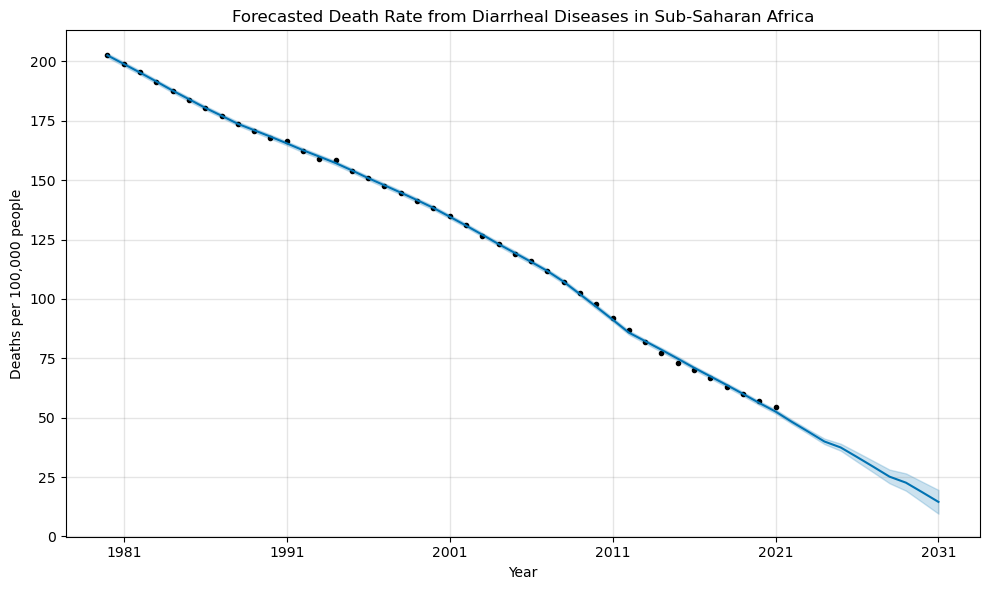

In [34]:
# Basic Prophet forecast plot
fig = model.plot(forecast)
plt.title(f"Forecasted Death Rate from Diarrheal Diseases in {region}")
plt.xlabel("Year")
plt.ylabel("Deaths per 100,000 people")
plt.grid(True)
plt.tight_layout()
plt.show()


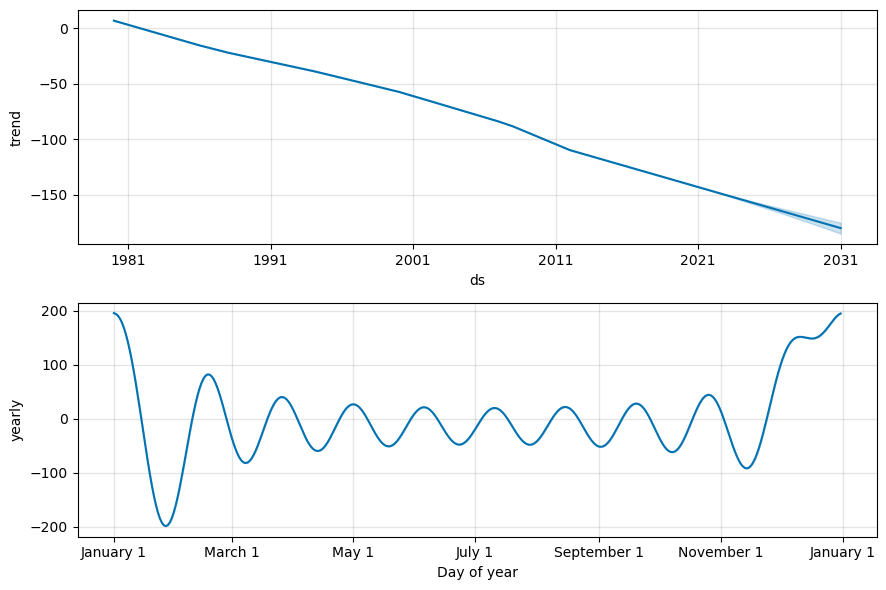

In [35]:
fig2 = model.plot_components(forecast)
plt.show()
